In [1]:
from tqdm import tqdm
import os
import argparse
import requests
from zipfile import ZipFile
import os

Unzip dataset

In [2]:
def clear_screen():
    """Clears the console screen irrespective of os used"""
    import platform
    if platform.system() == 'Windows':
        os.system('cls')
        return
    os.system('clear')

In [3]:
def unzip_file(source_name, destination):
    """ Unizips a zip file and stores the contents in destination folder.
    Parameters:
        source_name(str): Full path of the source path
        destination(str): Full folder path where contents of source_name will be stored.

    Returns: None
    """
    with ZipFile(source_name, 'r') as zipfile:
        # extracting all the files
        print(f'\tExtracting files of {source_name}')
        zipfile.extractall(destination)
        print(f'\tDone with {source_name}')
        
def make_folder(target_folder):
    """Creates folder if there is no folder in the specified path.
    Parameters: 
        target_folder(str): path of the folder which needs to be created.

    Returns: None
    """
    if not (os.path.isdir(target_folder)):
        print(f'Creating {target_folder} folder')
        os.mkdir(target_folder)



In [4]:
def main():
    # Clears the screen.
    clear_screen()

    # File names in a list.
    file_names = [
        f'stage1_train.zip' ]

    # Destination folder to store files.
    destination = os.path.join('dataset', 'stage1_train')
    # Make the destination folder.
    make_folder(os.path.join('dataset', 'stage1_train'))

    for file in file_names:
        path = os.path.join('dataset', file)
        unzip_file(path, destination)

if __name__ == "__main__":
    main()

	Extracting files of dataset/stage1_train.zip
	Done with dataset/stage1_train.zip


In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


Split the dataset to training+validation:test=9:1

In [6]:
import os
import random
import shutil
from shutil import copy2
trainfiles = os.listdir('./dataset/stage1_train')
num_train = len(trainfiles)
#print( "num_train: " + str(num_train) )
index_list = list(range(num_train))
#print(index_list)
random.shuffle(index_list)
num = 0
trainDir = './dataset/train'
testDir = './dataset/test'
for i in index_list:
    fileName = os.path.join('./dataset/stage1_train', trainfiles[i])
    if num < num_train*0.9:
        #print(str(fileName))
        shutil.move(fileName,trainDir)
    else:
        shutil.move(fileName,testDir)
    num += 1


Error: Destination path './dataset/train/20e209f6ffa120a72712e1b4c1d3e24d1339227e2936abd4bbd49a636fada423' already exists

In [2]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = './dataset/train/'
TEST_PATH = './dataset/test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [3]:

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

Getting and resizing train images and masks ... 


100%|██████████| 604/604 [05:00<00:00,  2.01it/s]


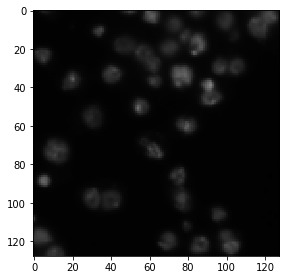

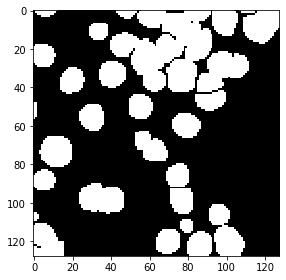

In [5]:
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [6]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [7]:
smooth = 1.

# Metric function
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [8]:
def get_unet(IMG_WIDTH=128,IMG_HEIGHT=128,IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=[dice_coef])
    return model

In [9]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-basicunet.h5', verbose=1, save_best_only=True)
# get u_net model
model = get_unet()
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=20, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 543 samples, validate on 61 samples
Epoch 1/50
543/543 [==============================] - 54s 99ms/step - loss: 0.4233 - dice_coef: 0.3697 - val_loss: 0.2303 - val_dice_coef: 0.6776

Epoch 00001: val_loss improved from inf to 0.23033, saving model to model-basicunet.h5
Epoch 2/50
543/543 [==============================] - 46s 85ms/step - loss: 0.2017 - dice_coef: 0.6900 - val_loss: 0.1858 - val_dice_coef: 0.7653

Epoch 00002: val_loss improved from 0.23033 to 0.18583, saving model to model-basicunet.h5
Epoch 3/50
543/543 [==============================] - 47s 87ms/step - loss: 0.1577 - dice_coef: 0.7654 - val_loss: 0.1552 - val_dice_coef: 0.8008

Epoch 00003: val_loss improved from 0.18583 to 0.15520, saving model to model-basicunet.h5
Epoch 4/50
543/543 [==============================] - 47s 86ms/step - loss: 0.1570 - dice_coef: 0.7618 - val_loss: 0.1184 - val_dice_coef: 0.8459

Epoch 00004: val_loss improved from 0.15520 to 0.11839, saving model to model-basicunet.h5
Epoch 5

In [10]:

# Get and resize test images and masks
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_test[n] = mask
    

Getting and resizing train images and masks ... 


100%|██████████| 67/67 [00:30<00:00,  2.19it/s]


In [11]:
model = load_model('model-basicunet.h5', custom_objects={'dice_coef': dice_coef})
model.evaluate(X_test, Y_test, batch_size=1, verbose=0, sample_weight=None, steps=None)


[0.09884367941586829, 0.8693451881408691]

In [12]:
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

67/67 [==============================] - 2s 27ms/step


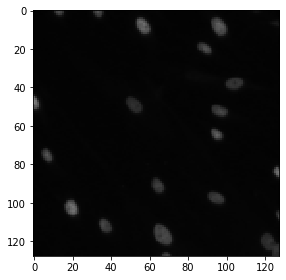

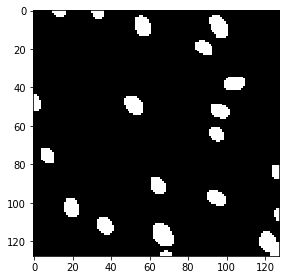

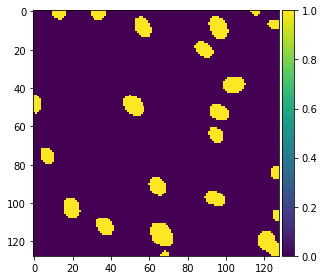

In [13]:
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix]/255)
plt.show()
imshow(np.squeeze(Y_test[ix]))
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()

In [91]:
from PIL import Image
TEST_PATH2 = './dataset2/image/'
test_ids2 = next(os.walk(TEST_PATH2))[2]
d2_train = np.zeros((len(test_ids2), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
print(len(test_ids2))
for n, id_ in tqdm(enumerate(test_ids2), total=len(test_ids2)):
    path = TEST_PATH2
    img = Image.open(path  + id_ )
    img = img.convert('RGB')
    img = np.array(img) 
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    d2_train[n] = img

Getting and resizing train images and masks ... 


100%|██████████| 6/6 [00:00<00:00, 38.28it/s]

6


In [92]:
model = load_model('model-basicunet.h5', custom_objects={'dice_coef': dice_coef})

preds_test2 = model.predict(d2_train, verbose=1)

# Threshold predictions
preds_test_t2 = (preds_test2 > 0.5).astype(np.uint8)

6/6 [==============================] - 1s 130ms/step


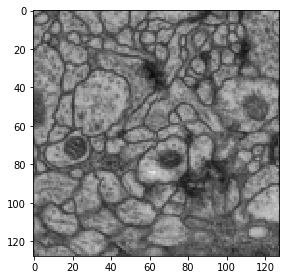

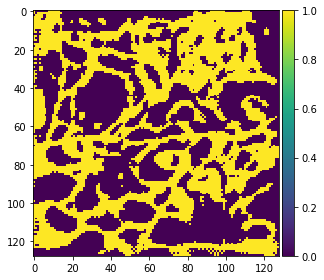

In [93]:
ix = random.randint(0, len(preds_test_t2))
imshow(d2_train[ix])
plt.show()
imshow(np.squeeze(preds_test_t2[ix]))
plt.show()